# Explore Quantile Regression for GBDTs
Here, we explore how different solutions for quantile regression of gradient boosted decision tree algorithms perform on a toy problem 

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import warnings

warnings.simplefilter("ignore")

import os
import sys
import numpy as np

from functools import partial
from sklearn.model_selection import train_test_split

from itertools import product
from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-colorblind")
PLT_COLOR = plt.rcParams["axes.prop_cycle"].by_key()["color"]
PLT_LINES = ["-", "--", ":", "-."]
PLT_CYCLER = cycler(color=PLT_COLOR * 2) + cycler(linestyle=PLT_LINES * 3)

import pandas as pd

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.plotting.register_matplotlib_converters()

import logging

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

np.random.seed(0)

# Parameters

In [2]:
QUANTILE = 0.95

corresponding to 90% confidence.

# Helper Functions

In [3]:
def plot_result(ax, alpha, preds, data, f):

    assert len(preds) == 3, "Predicitons require 3 entries"

    y_lower, y_pred, y_upper = preds
    X_train, y_train, X_test, y_test = data

    fill_color = PLT_COLOR[3]
    ax.plot(
        X_test,
        y_test,
        ".",
        color=PLT_COLOR[0],
        alpha=0.3,
        markersize=2,
        label="y_test",
    )

    ax.fill(
        np.concatenate([X_test, X_test[::-1]]),
        np.concatenate([y_upper, y_lower[::-1]]),
        alpha=0.5,
        fc=fill_color,
        ec="none",
        label="{:.0%} prediction interval".format(2 * alpha - 1),
    )
    ax.plot(X_test, y_upper, "-", color=fill_color)
    ax.plot(X_test, y_lower, "-", color=fill_color)
    ax.plot(
        np.array(sorted(X_train)),
        f(np.array(sorted(X_train))),
        ":",
        color="gray",
        label="Truth",
    )
    ax.plot(X_test, y_pred, "-k", label="Prediction")
    ax.plot(
        np.array(sorted(X_train)), f(np.array(sorted(X_train))), "-", label="Truth",
    )

    ax.legend(loc="upper left")
    return ax

In [4]:
def f(x):
    return (np.sin(x) + np.cos(2 * x) + np.sin(0.5 * x)) / 3


def add_noise(y, X):
    dy = np.random.random(y.shape) / 5 + np.abs(X[:, 0]) / 100
    y += np.random.normal(0, dy)
    return y


def generate_data(xmin=-10, xmax=30, size=10000):
    """
    Generates data sample as seen in 'Prediction Intervals for Gradient Boosting Regression'
    https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html
    """

    X_train = np.atleast_2d(np.random.uniform(xmin, xmax, size=size)).T
    X_train = X_train.astype(np.float32)

    X_test = np.atleast_2d(np.linspace(xmin, xmax, size)).T
    X_test = X_test.astype(np.float32)

    # Noisy train/test data:
    y_train = f(X_train).ravel()
    y_train = add_noise(y_train, X_train).astype(np.float32)

    y_test = f(X_test).ravel()
    y_test = add_noise(y_test, X_test).astype(np.float32)

    return X_train, y_train, X_test, y_test

# Generate Toy Data

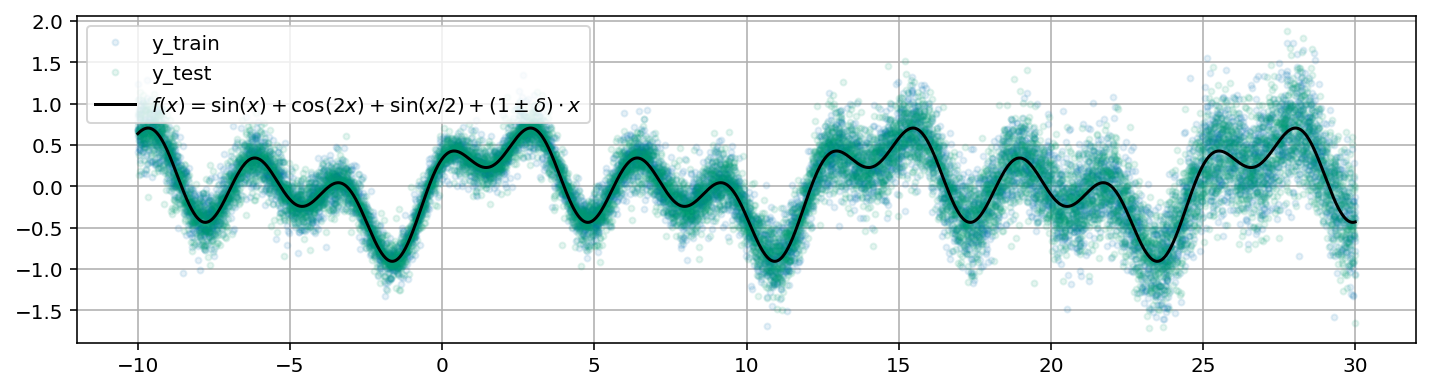

In [5]:
X_train, y_train, X_test, y_test = generate_data()
data = (X_train, y_train, X_test, y_test)

flabel = r"$f(x)=\sin(x) + \cos(2x) + \sin(x/2) + (1\pm\delta)\cdot x $"

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
_ = ax.plot(X_train, y_train, marker=".", alpha=0.1, linestyle="none", label="y_train")
_ = ax.plot(X_test, y_test, marker=".", alpha=0.1, linestyle="none", label="y_test")
_ = ax.plot(np.array(sorted(X_train)), f(np.array(sorted(X_train))), "k", label=flabel)
_ = ax.grid()
_ = plt.legend()

# Native Quantile Regressions for GBDTs
* scikit-learn: Native implementation, but sub-standard performance of estimator, cf.:<br>
https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html
* CatBoost: Native implementation, e.g.:<br>
https://brendanhasz.github.io/2018/12/15/quantile-regression
* LightGBM: Native implementation, e.g.:<br>
http://jmarkhou.com/lgbqr/<br>
https://towardsdatascience.com/lightgbm-for-quantile-regression-4288d0bb23fd
* XGBoost: No native implementation, requires customized loss function (see below).

In [6]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


sklearn_params = {
    "n_estimators": 500,
    "max_depth": 5,
    "learning_rate": 0.1,
    "min_samples_leaf": 9,
    "min_samples_split": 9,
}

cat_params = {"verbose": 0, "n_estimators": 500}

lgb_params = {"force_row_wise": True, "verbose": -1}

In [7]:
skl_preds = list()
cat_preds = list()
lgb_preds = list()
for q in [1 - QUANTILE, 0.5, QUANTILE]:
    print("prediction of {:.0%} quantile".format(q))

    # Scikit-Learn:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=q, **sklearn_params)
    skl_preds.append(gbr.fit(X_train, y_train).predict(X_test))

    # CatBoost:
    gbr = CatBoostRegressor(loss_function=f"Quantile:alpha={q}", **cat_params)
    cat_preds.append(gbr.fit(X_train, y_train).predict(X_test))

    # LightGBM
    gbr = LGBMRegressor(objective="quantile", alpha=q, **lgb_params)
    lgb_preds.append(gbr.fit(X_train, y_train).predict(X_test))

preds = {
    "sklearn": skl_preds,
    "CatBoost": cat_preds,
    "LightGBM": lgb_preds,
}

prediction of 5% quantile
prediction of 50% quantile
prediction of 95% quantile


sklearn  :  6.5% ( 6.5%) test data larger (smaller) than interval
CatBoost :  5.5% ( 5.5%) test data larger (smaller) than interval
LightGBM :  6.3% ( 5.4%) test data larger (smaller) than interval
expected :  5.0%



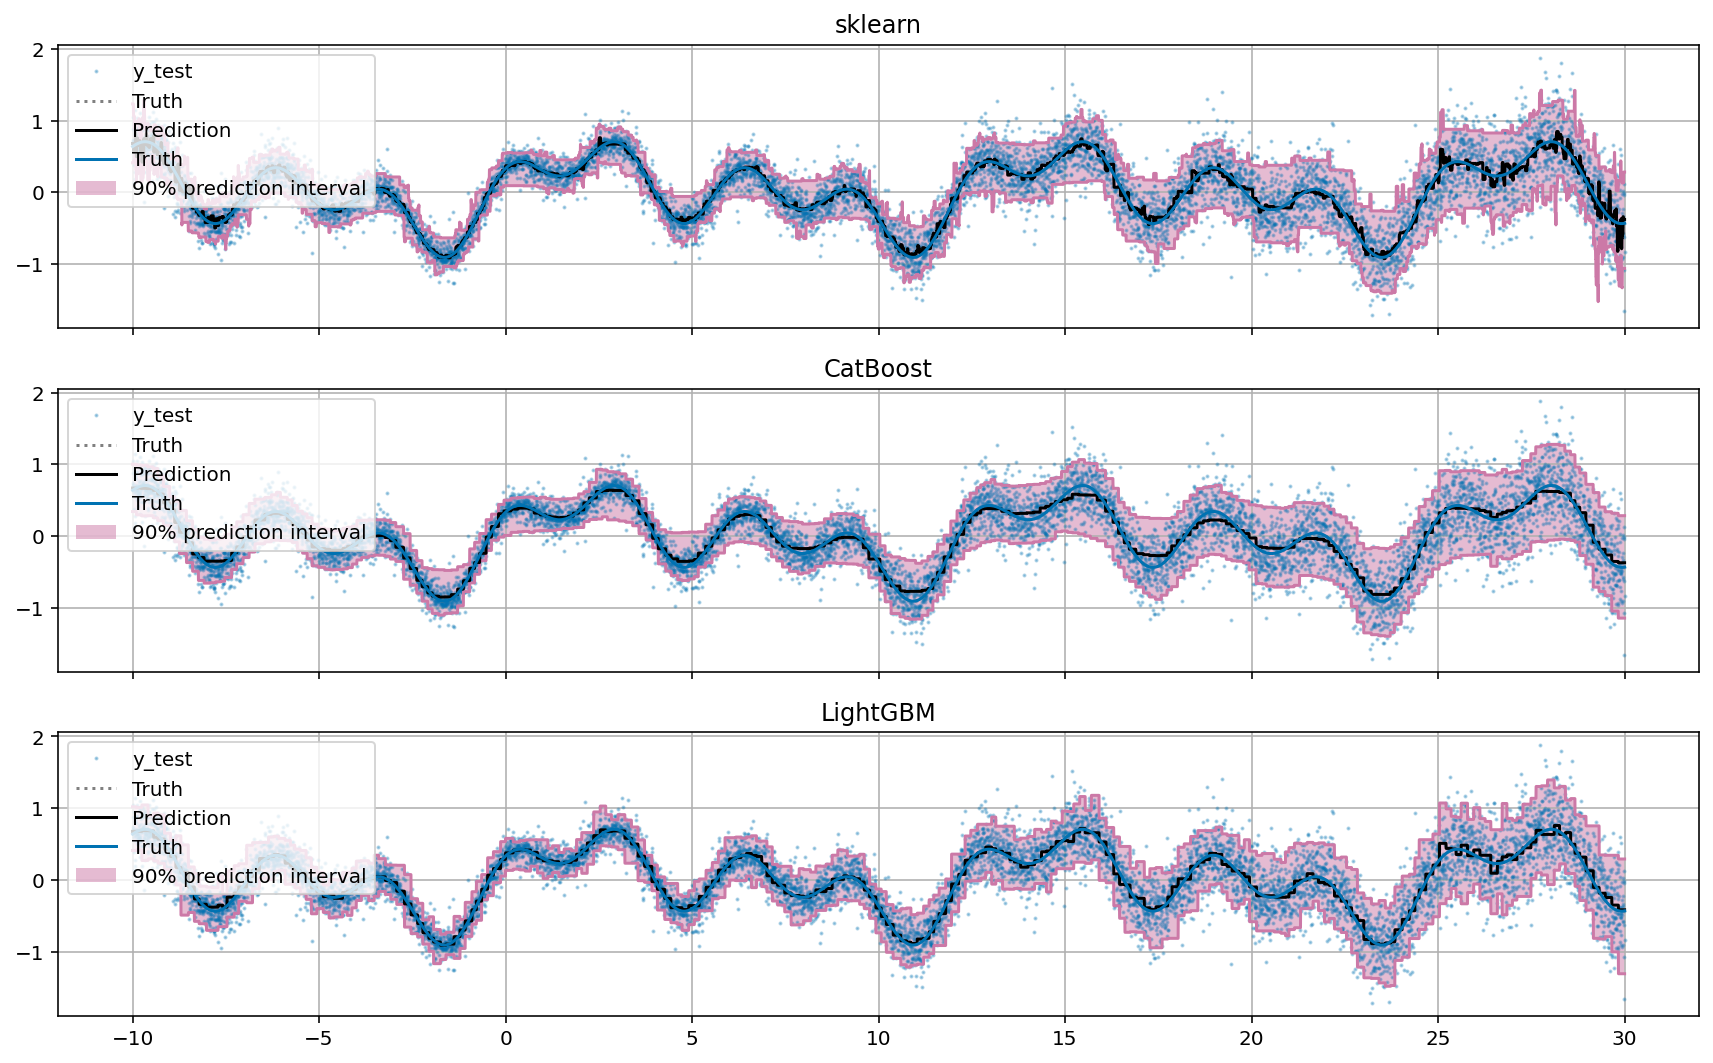

In [8]:
s = "{:<9}: {:4.1f}% ({:4.1f}%) test data larger (smaller) than interval".format

for t, p in preds.items():
    smaller = (p[2] < data[3]).mean()
    larger = (p[0] > data[3]).mean()
    print(s(t, larger * 100, smaller * 100))

print("{:<9}:  {:4.1%}\n".format("expected", 1 - QUANTILE))

fig, ax = plt.subplots(len(preds), 1, figsize=(12, 2.5 * len(preds)), sharex=True)
for idx, (t, p) in enumerate(preds.items()):
    _ = plot_result(ax=ax[idx], alpha=QUANTILE, preds=p, data=data, f=f)
    ax[idx].set_title(t)
    ax[idx].grid()
plt.tight_layout()

# Quantile Loss
Usually, quantile regression relies on an asymmetric penalization of errors with the pinball loss:<br>

$
\begin{align}
\label{eq:qLoss}
L_{q}(\varepsilon=y_\text{true} - y_\text{pred})=\begin{cases}
q\cdot\varepsilon & \text{if }\varepsilon\geq0\\
(1-q)\cdot\varepsilon & \text{if }\varepsilon<0
\end{cases}
\end{align}
$
<br>
<br>
$\rightarrow$ The median loss (i.e. the 50% quantile) is the symmetric MAE/2.

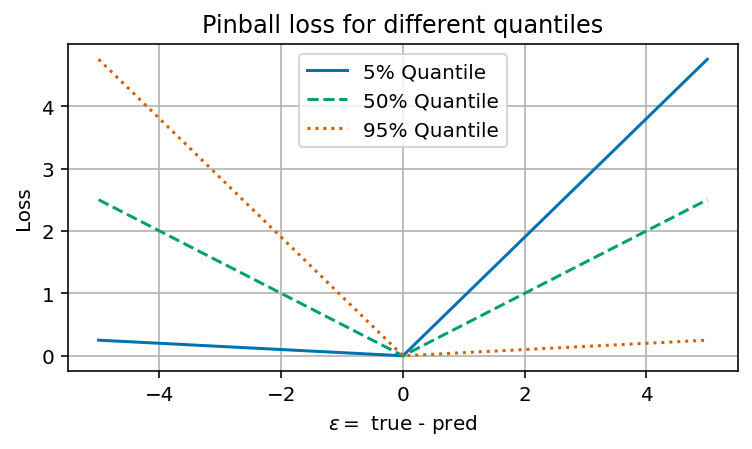

In [9]:
def quantile_loss(y_true, y_pred, quantile):
    residual = y_true - y_pred
    return np.maximum(quantile * residual, (quantile - 1) * residual)


xx = np.linspace(-5, 5, 101)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.set_prop_cycle(PLT_CYCLER)
for q in [1 - QUANTILE, 0.5, QUANTILE]:
    _ = ax.plot(xx, quantile_loss(0, xx, q), label="{:.0%} Quantile".format(q))
_ = ax.legend()
_ = ax.set_title("Pinball loss for different quantiles")
_ = ax.set_xlabel(r"$\varepsilon=\hspace{.03}$ true - pred")
_ = ax.set_ylabel("Loss")
_ = ax.grid()

# Customized Quantile Loss Example for XGBoost
* Using the above pinball loss for GBDTs would worsen the model performance (vanishing gradient, "zero-everywhere" hessian).<br>
* Instead, we can smooth the quantile loss (the vanishing gradient problem remains):<br>

$
\begin{align}
L_{q}(\varepsilon)&=\begin{cases}
q\cdot\ln(\cosh(\varepsilon)) & \text{if }\varepsilon\geq0\\
(1-q)\cdot\ln\left(\cosh(\varepsilon)\right) & \text{if }\varepsilon<0
\end{cases}\\\\
\frac{d}{d \varepsilon}L_{q}(\varepsilon) &=\begin{cases}
q\cdot\tanh(\varepsilon) \\
(1-q)\cdot\tanh(\varepsilon)
\end{cases}\\\\
\frac{d^2}{d \varepsilon^2}L_{q}(\varepsilon) &=\begin{cases}
q\cdot\text{sech}^2(\varepsilon) \\
(1-q)\cdot\text{sech}^2(\varepsilon)
\end{cases}
\end{align}
$
<br>

* Alternatively, we could use a similarly rotated Huber loss.

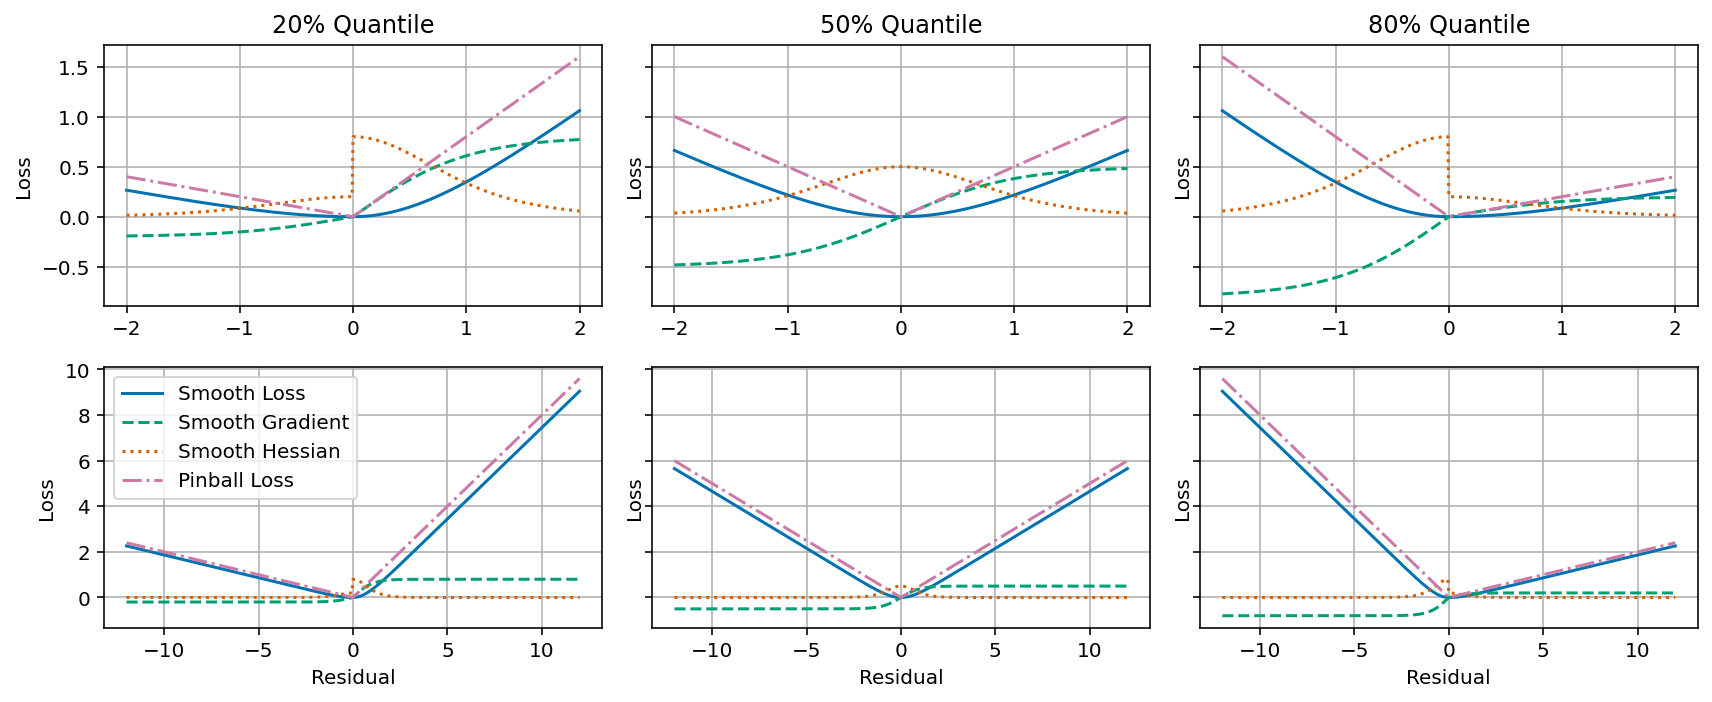

In [10]:
def quantile_loss(y_true, y_pred, q=0.5):
    """Quantile (pinball) loss."""
    err = y_pred - y_true
    return abs(np.where(err < 0, q * err, (1 - q) * err))


def quantile_loss_smooth(y_true, y_pred, q=0.5):
    """Smooth ln(cosh(x)) quantile loss."""
    err = y_pred - y_true
    return np.where(err < 0, q * np.log(np.cosh(err)), (1 - q) * np.log(np.cosh(err)))


def quantile_objective_smooth(y_true, y_pred, q=0.5):
    """Objective function returning gradient and hessian of the smooth quantile loss."""
    err = y_pred - y_true
    grad = np.where(err < 0, q * np.tanh(err), (1 - q) * np.tanh(err))
    hess = np.where(err < 0, q * np.cosh(err) ** -2, (1 - q) * np.cosh(err) ** -2)
    return grad, hess


fig, axs = plt.subplots(2, 3, figsize=(12, 5), sharey="row")
axs = axs.flat

xx_list = [np.linspace(-2, 2, 501), np.linspace(-12, 12, 501)]
q_list = [0.2, 0.5, 0.8]
for idx, (x, q) in enumerate(product(xx_list, q_list)):

    ax = axs[idx]
    ax.set_prop_cycle(PLT_CYCLER)

    _ = ax.plot(x, quantile_loss_smooth(0, x, q), label="Smooth Loss")
    _ = ax.plot(x, quantile_objective_smooth(0, x, q)[0], label="Smooth Gradient")
    _ = ax.plot(x, quantile_objective_smooth(0, x, q)[1], label="Smooth Hessian")
    _ = ax.plot(x, quantile_loss(0, x, q), label="Pinball Loss")

    _ = ax.grid()
    _ = ax.set_ylabel("Loss")

    if idx < 3:
        _ = ax.set_title("{:.0%} Quantile".format(q))
    if idx == 3:
        _ = ax.legend()
    if idx > 2:
        _ = ax.set_xlabel("Residual")

plt.tight_layout()

In [11]:
xgb_params = {"random_state": 0, "verbosity": 0, "lambda": 50, "nestimators": 500}

xgb_preds = list()
for q in [1 - QUANTILE, 0.5, QUANTILE]:
    print("prediction of {:.0%} quantile".format(q))

    objective = partial(quantile_objective_smooth, q=q)
    gbr = XGBRegressor(objective=objective, **xgb_params)
    xgb_preds.append(gbr.fit(X_train, y_train).predict(X_test))

prediction of 5% quantile
prediction of 50% quantile
prediction of 95% quantile


xgb:     13.2% (12.7%) test data larger (smaller) than interval.
expected: 5.0%



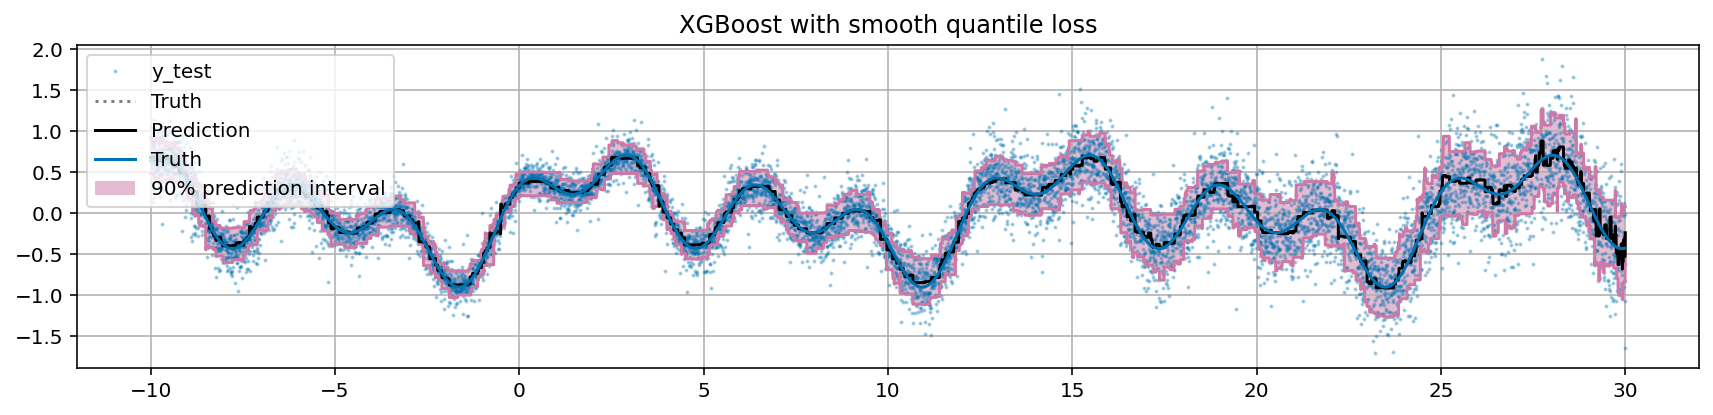

In [12]:
smaller = (xgb_preds[2] < data[3]).mean()
larger = (xgb_preds[0] > data[3]).mean()
s = "{:<8} {:4.1f}% ({:4.1f}%) test data larger (smaller) than interval.".format
print(s("xgb:", larger * 100, smaller * 100))
print("expected: {:4.1%}\n".format(1 - QUANTILE))

fig, ax = plt.subplots(1, 1, figsize=(12, 3), sharex=True)
_ = plot_result(ax=ax, alpha=QUANTILE, preds=xgb_preds, data=data, f=f)
ax.set_title("XGBoost with smooth quantile loss")
ax.grid()
plt.tight_layout()

* XGBoost WTF! Simply using the respective (smooth) pinball loss doesn't do the trick, at least not at first try. Might require better scaling of the training data.
* Alternative solution: randomization of gradient and hessian, see <br>
https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b
* At first try, this is VERY unstable, though, and requires grid search for gradient-parameters. :(